In [2]:
import numpy as np
import matplotlib.pyplot as plt

Here we define the constants to be used with our models.

In [7]:
#Constants

r = 0.01 # risk-free interest rate
y = 3 # dividend mean
pf = 0 # fundamental price
N = 50 #time steps
sigma = 0.1 # standard deviation
    

We have directly used Anufriev and Hommes 2009 paper to implement our models, thus the slight differences in notations and implementation.

### 1. Chaos with 3 simple strategies

Here we define 3 constant predictors and observe for 3 different values of parameter $\beta$ the price evolution.

In [405]:
S = 3 # number of strategies

def strategy(g): # closure to adjust parameter easily
    def fun_0(i, p, p_e, t): # our strategies
        if i == 0:
            return 0
        elif i == 1:
            return g
        elif i == 2:
            return -g
    return fun_0

def brock_hommes_chaos(beta, eta, delta, nh_ini, p_ini, f):
    eps = np.random.normal(0, sigma, N) # gaussian noise
    p = np.zeros(N) # prices
    p[0], p[1] = p_ini[0], p_ini[1] # initial prices
    p_e = np.zeros((S,N)) # heuristics forecasts
    n_h = np.zeros((S,N)) # impacts of our different heuristics
    n_h[:,1], n_h[:,2] = nh_ini.T, nh_ini.T # initial heuristics distribution
    n = np.zeros(N) # share of robot traders
    U = np.zeros((S,N)) # performance of heuristics
    Z = np.zeros(N) # normalization factor

    # initialization
    for t in range(2, 4):
        for i in range(0,S):
            p_e[i, t] = f(i, p, p_e, t)
        if t == 2:
            n[t] = 1 - np.exp((-1/200)*np.abs(p[t-1] - pf))
        p[t] = 1/(1+r)*((1 - n[t])*(np.sum(n_h[:,t-1]*p_e[:,t])) + n[t]*pf + y + eps[t])

    # process
    for t in range(4, N):
        for i in range(0, S):
            U[i,t-1] = (1 - eta)*U[i,t-2] + eta*(p[t-1] + eps[t-1] - (1 + r)*p[t-2])*(pf + f(i, p, p_e, t) - (1 + r)*p[t-2])
        Z[t-1] = np.sum(np.exp(beta*U[:,t-1]))
        n_h[:,t] = delta*n_h[:,t-1] + (1-delta)*(np.exp(beta*U[:,t-1])/Z[t-1])
        for i in range(0,S):
            p_e[i, t] = f(i, p, p_e, t)
        avg_pred = np.sum(n_h[:,t]*p_e[:,t])
        n[t] =  1 - np.exp((-1/200)*np.abs(p[t-1] - pf))
        p[t] = 1/(1+r)*((1 - n[t])*avg_pred + n[t]*pf + y + eps[t])

    return p - pf, p_e - pf, n_h

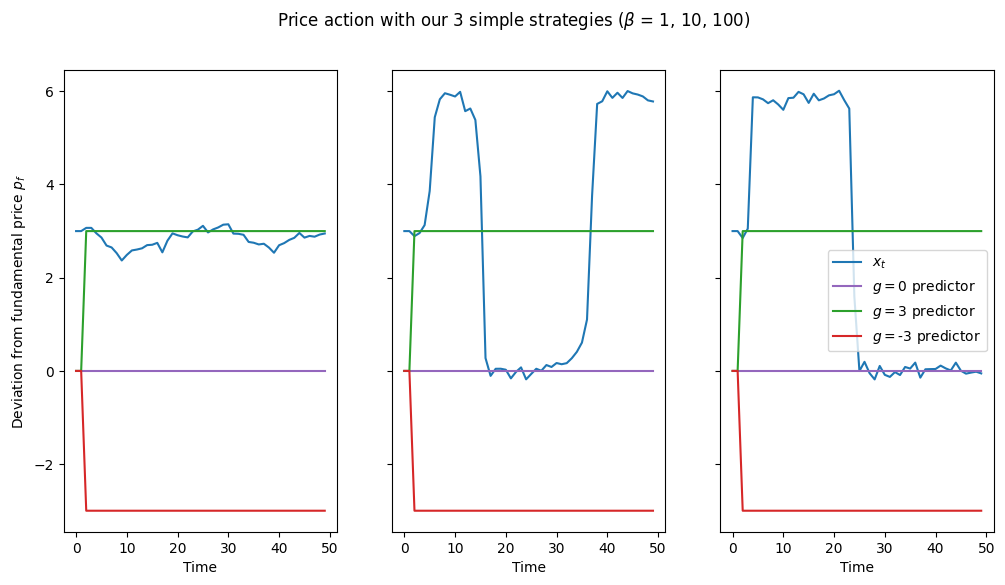

In [439]:
g = 3
beta = [1, 10, 100]
x = np.zeros((S, N))
xe = np.zeros((S, S, N))
nh = np.zeros((S, S, N))

fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
for i in range(3):
    x[i,:], xe[i,:,:], nh[i,:,:] = brock_hommes_chaos(beta[i], 0.1, 0, np.array([1/3, 1/3, 1/3]), np.array([3, 3]), strategy(g))
    axs[i].plot(x[i,:], label='$x_t$', c='tab:blue')
    axs[i].plot(xe[i,0,:], label='$g = 0$ predictor', c='tab:purple')
    axs[i].plot(xe[i,1,:], label=f'$g =${g} predictor', c='tab:green')
    axs[i].plot(xe[i,2,:], label=f'$g =$-{g} predictor', c='tab:red')

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Deviation from fundamental price $p_f$')
    ax.label_outer()

plt.suptitle(f'Price action with our 3 simple strategies ($\\beta$ = {beta[0]}, {beta[1]}, {beta[2]})')
plt.legend()
plt.show()

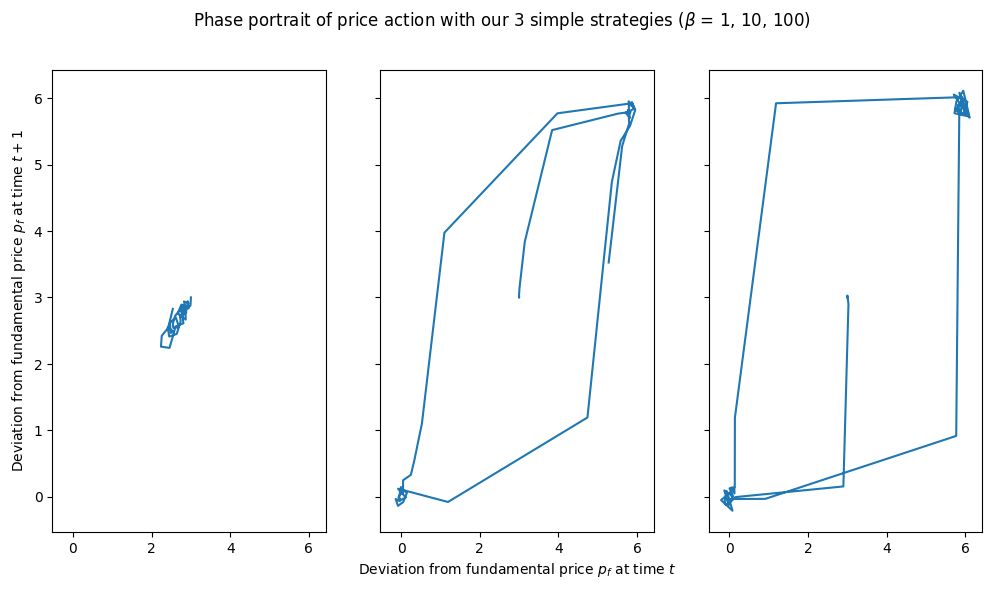

In [447]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True)
for i in range(3):
    x[i,:], xe[i,:,:], nh[i,:,:] = brock_hommes_chaos(beta[i], 0.1, 0, np.array([1/3, 1/3, 1/3]), np.array([3, 3]), strategy(g))
    axs[i].plot(x[i,:-1], x[i,1:], c='tab:blue')

for ax in axs.flat:
    ax.set(ylabel='Deviation from fundamental price $p_f$ at time $t+1$')
    ax.label_outer()

axs[1].set(xlabel='Deviation from fundamental price $p_f$ at time $t$')

plt.suptitle(f'Phase portrait of price action with our 3 simple strategies ($\\beta$ = {beta[0]}, {beta[1]}, {beta[2]})')
plt.show()

We notice unstability with $\beta=10$ and $\beta=100$. Indeed, $\beta$ represents the sensivity of agents, meaning that with higher values of $\beta$, agents tend to switch more easily to another strategies.

### 2. Empirical strategies

In [4]:
S = 5 # number of strategies

def fun(i, p, p_e, t):
    if i == 0:
        return 0.65*p[t-1] + 0.35*p_e[0,t-1]
    elif i == 1:
        return p[t-1] + 0.4*(p[t-1] - p[t-2])
    elif i == 2:
        return p[t-1] + 1.3*(p[t-1] - p[t-2])
    elif i == 3:
        return 0.5*pf + 1.5*p[t-1] - p[t-2]
    else:
        return 0.5*np.mean(p[:t-1]) + 1.5*p[t-1] - p[t-2]

def brock_hommes(beta, eta, delta, nh_ini, p_ini, f):
    eps = np.random.normal(0, sigma, N) # gaussian noise
    p = np.zeros(N) # prices
    p[0], p[1] = p_ini[0], p_ini[1]
    p_e = np.zeros((S,N)) # heuristics forecasts
    n_h = np.zeros((S,N)) # impacts of our different heuristics
    n_h[:,1], n_h[:,2] = nh_ini.T, nh_ini.T
    n = np.zeros(N) # share of robot traders
    U = np.zeros((S,N)) # performance of heuristics
    Z = np.zeros(N) # normalization factor

    # initialization
    for t in range(2, 4):
        for i in range(0,S):
            p_e[i, t] = f(i, p, p_e, t)
        if t == 2:
            n[t] = 1 - np.exp((-1/200)*np.abs(p[t-1] - pf))
        p[t] = 1/(1+r)*((1 - n[t])*(np.sum(n_h[:,t-1]*p_e[:,t])) + n[t]*pf + y + eps[t])

    # process
    for t in range(4, N):
        for i in range(0, S):
            U[i,t-1] = (1 - eta)*U[i,t-2] + eta*(p[t-1] + eps[t-1] - (1 + r)*p[t-2])*(pf + f(i, p, p_e, t) - (1 + r)*p[t-2])
        Z[t-1] = np.sum(np.exp(beta*U[:,t-1]))
        n_h[:,t] = delta*n_h[:,t-1] + (1-delta)*(np.exp(beta*U[:,t-1])/Z[t-1])
        for i in range(0,S):
            p_e[i, t] = f(i, p, p_e, t)
        avg_pred = np.sum(n_h[:,t]*p_e[:,t])
        n[t] =  1 - np.exp((-1/200)*np.abs(p[t-1] - pf))
        p[t] = 1/(1+r)*((1 - n[t])*avg_pred + n[t]*pf + y + eps[t])

    return p - pf, p_e - pf, n_h

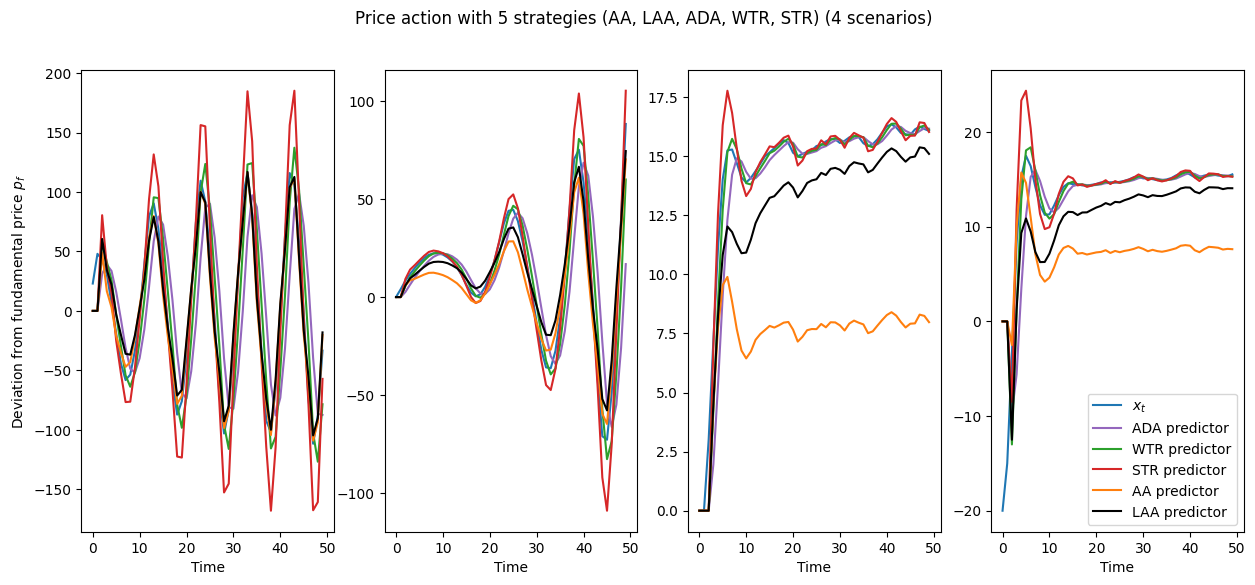

In [146]:
beta = [0.06, 0.23, 0.0001463, 0.0036]
eta = [0.3, 0.13791, 1.2632, 0.0036]
x = np.zeros((S, N))
xe = np.zeros((S, S, N))
nh = np.zeros((S, S, N))
starting_prices = np.array([[23,48], [0,4], [0,0], [-20,-15]])

fig, axs = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    x[i,:], xe[i,:,:], nh[i,:,:] = brock_hommes(beta[i], eta[i], 0, np.array([1/8, 1/4, 1/16, 1/2, 1/16]), starting_prices[i,:], fun)
    axs[i].plot(x[i,:], label='$x_t$', c='tab:blue')
    axs[i].plot(xe[i,0,:], label='ADA predictor', c='tab:purple')
    axs[i].plot(xe[i,1,:], label=f'WTR predictor', c='tab:green')
    axs[i].plot(xe[i,2,:], label=f'STR predictor', c='tab:red')
    axs[i].plot(xe[i,3,:], label=f'AA predictor', c='tab:orange')
    axs[i].plot(xe[i,4,:], label=f'LAA predictor', c='k')

for ax in axs.flat:
    ax.set(xlabel='Time')

axs[0].set(ylabel='Deviation from fundamental price $p_f$')

plt.suptitle(f'Price action with 5 strategies (AA, LAA, ADA, WTR, STR) (4 scenarios)')
plt.legend()
plt.show()

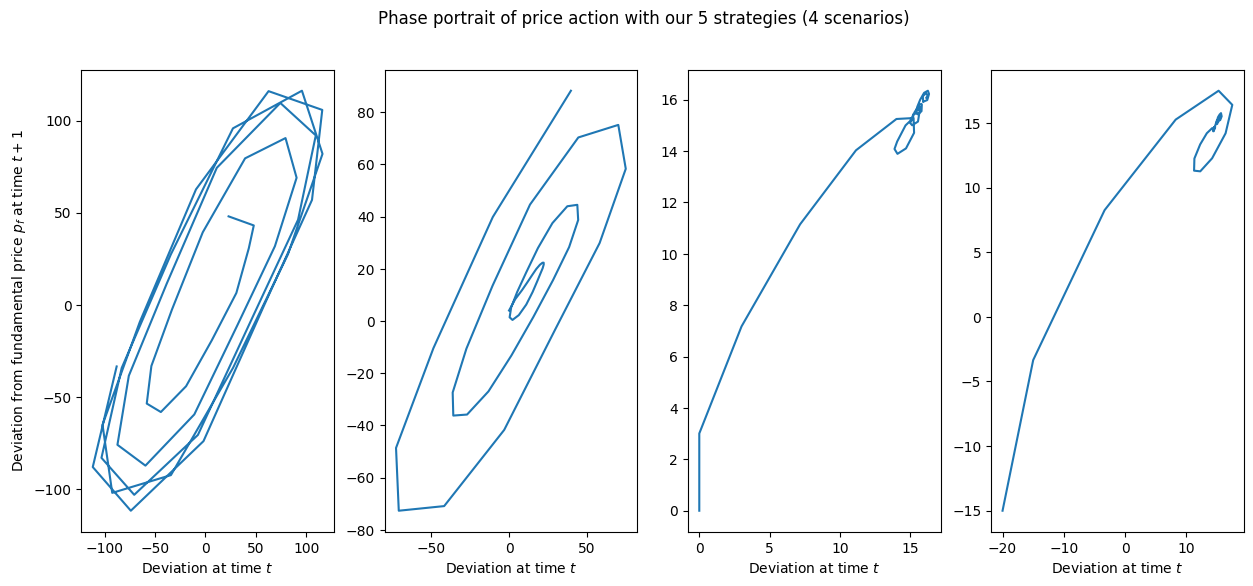

In [147]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axs[i].plot(x[i,:-1], x[i,1:], c='tab:blue')

for ax in axs.flat:
    ax.set(xlabel='Deviation at time $t$')

axs[0].set(ylabel='Deviation from fundamental price $p_f$ at time $t+1$')
    
plt.suptitle(f'Phase portrait of price action with our 5 strategies (4 scenarios)')
plt.show()

As we can see, some are stable while others are not. This is entirely determined by the choice of parameters. However, it seems difficult to predict accurately what parameter values will give a stable result.

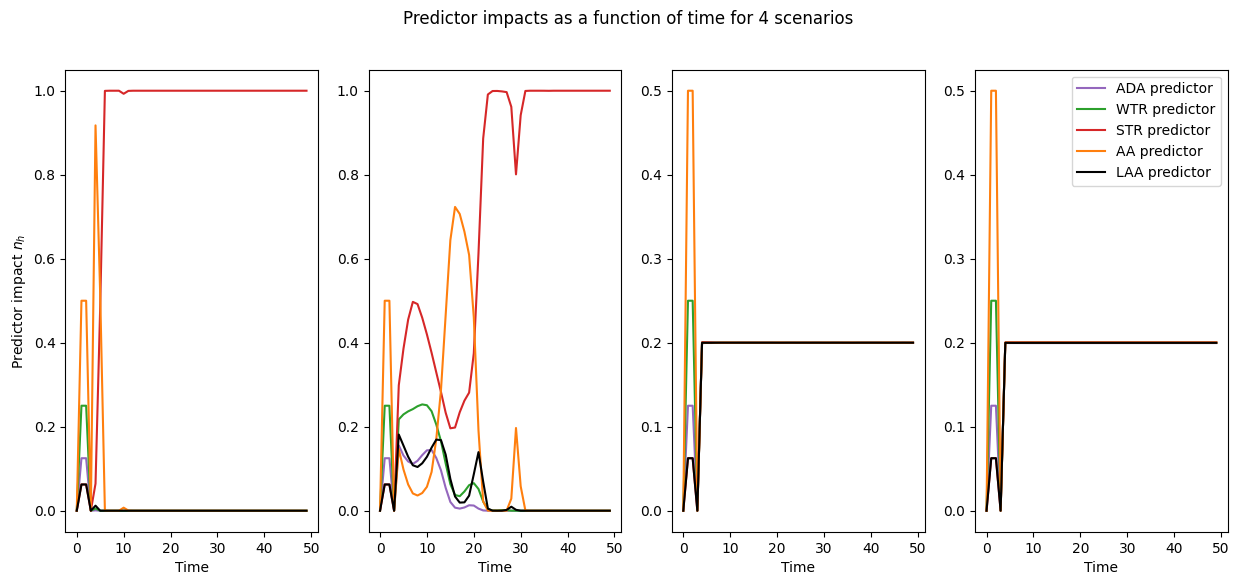

In [148]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axs[i].plot(nh[i,0,:], label='ADA predictor', c='tab:purple')
    axs[i].plot(nh[i,1,:], label=f'WTR predictor', c='tab:green')
    axs[i].plot(nh[i,2,:], label=f'STR predictor', c='tab:red')
    axs[i].plot(nh[i,3,:], label=f'AA predictor', c='tab:orange')
    axs[i].plot(nh[i,4,:], label=f'LAA predictor', c='k')

for ax in axs.flat:
    ax.set(xlabel='Time')

axs[0].set(ylabel='Predictor impact $n_h$')

plt.suptitle(f'Predictor impacts as a function of time for 4 scenarios')
plt.legend()
plt.show()

### 3. Technical Analysis

In [47]:
S = 3 
theta = 5
M = 2
alpha = 0.3
Ns = 4
# We implement 3 predictors.

def fun(i, p, p_e, t):
    if i == 0:
        return p[t-1] + (1/theta)*(p[t-1] - p[t-theta])
    elif i == 1:
        return p[t-1] + p[t-1] - (1/M)*np.sum(p[t-M:t])
    else:
        return p[t-1] + alpha*(p[t-1] - p[t-2]) - (1-alpha)*(p[t-2] - p[t-3])

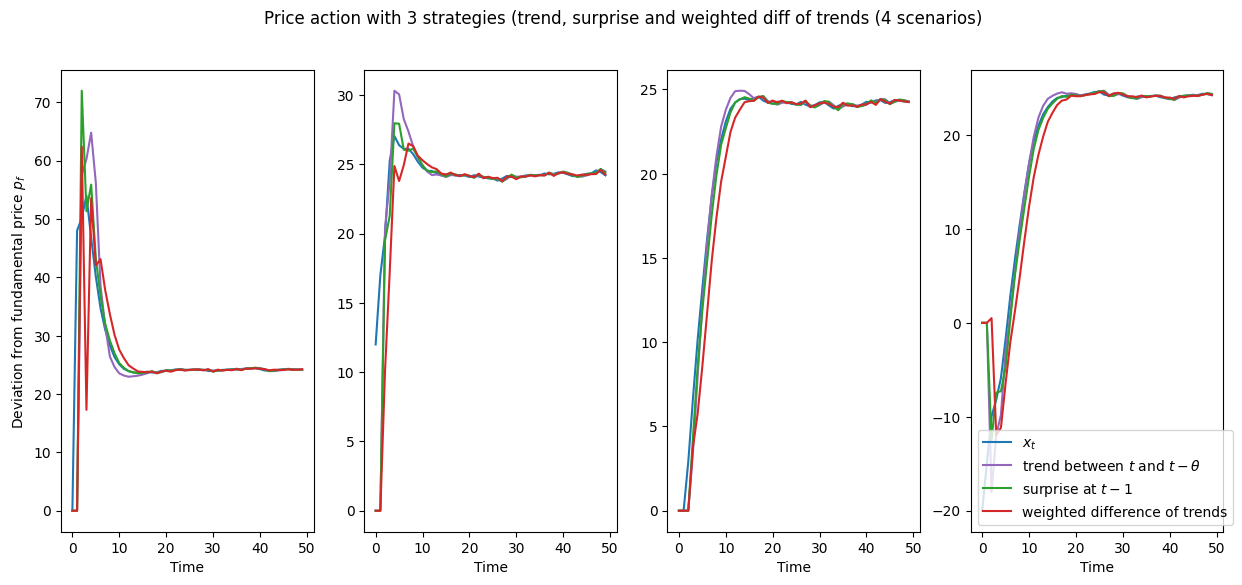

In [48]:
beta = [0.001, 0.009, 0.045, 0.0036]
eta = [0.03, 0.01, 0.07, 0.0036]
x = np.zeros((Ns, N))
xe = np.zeros((Ns, S, N))
nh = np.zeros((Ns, S, N))
starting_prices = np.array([[0,48], [12,17], [0,0], [-20,-15]])

fig, axs = plt.subplots(1, Ns, figsize=(15, 6))
for i in range(Ns):
    x[i,:], xe[i,:,:], nh[i,:,:] = brock_hommes(beta[i], eta[i], 0, np.array([2/3, 1/6, 1/6]), starting_prices[i,:], fun)
    axs[i].plot(x[i,:], label='$x_t$', c='tab:blue')
    axs[i].plot(xe[i,0,:], label='trend between $t$ and $t-\\theta$', c='tab:purple')
    axs[i].plot(xe[i,1,:], label=f'surprise at $t-1$', c='tab:green')
    axs[i].plot(xe[i,2,:], label=f'weighted difference of trends', c='tab:red')

for ax in axs.flat:
    ax.set(xlabel='Time')

axs[0].set(ylabel='Deviation from fundamental price $p_f$')

plt.suptitle(f'Price action with 3 strategies (trend, surprise and weighted diff of trends (4 scenarios)')
plt.legend()
plt.show()

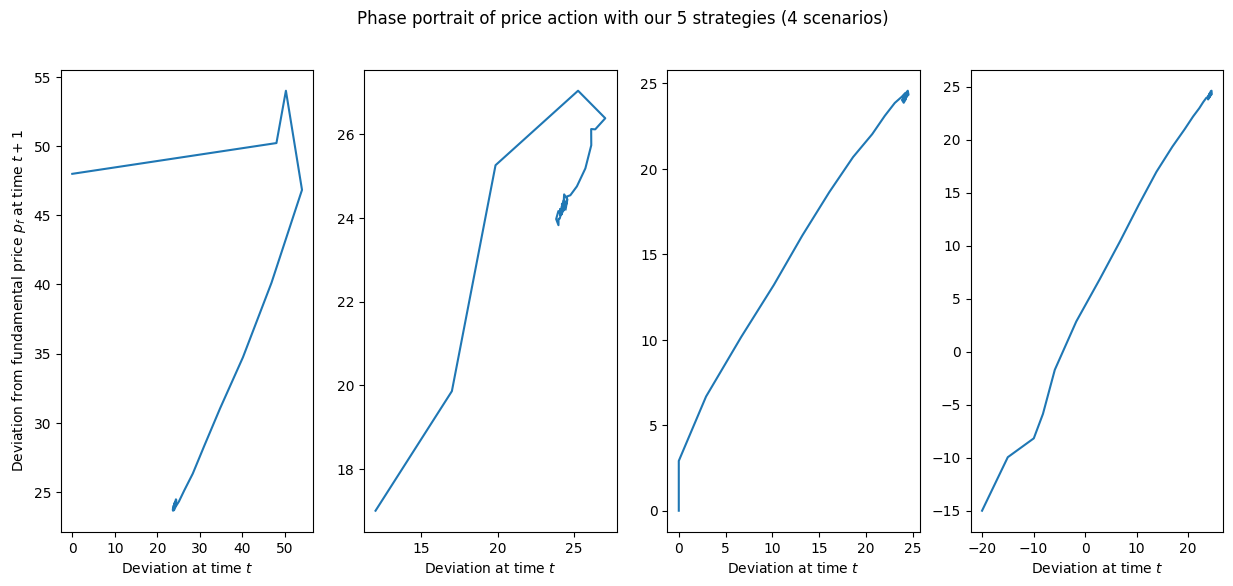

In [49]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axs[i].plot(x[i,:-1], x[i,1:], c='tab:blue')

for ax in axs.flat:
    ax.set(xlabel='Deviation at time $t$')

axs[0].set(ylabel='Deviation from fundamental price $p_f$ at time $t+1$')
    
plt.suptitle(f'Phase portrait of price action with our 5 strategies (4 scenarios)')
plt.show()

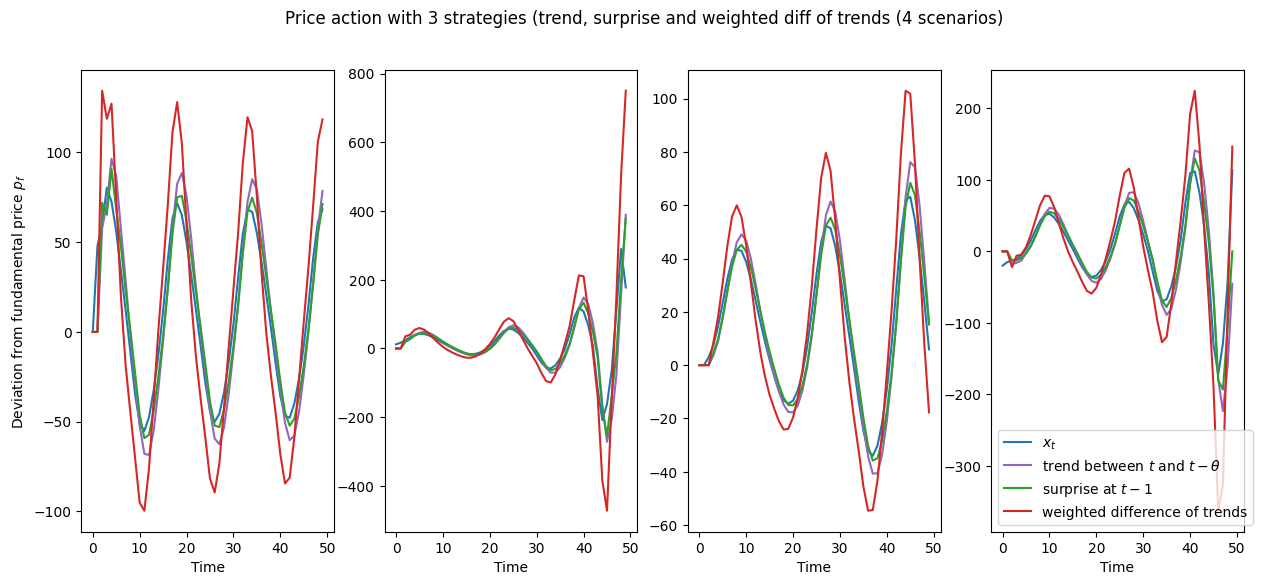

In [53]:
alpha = 1.8

beta = [0.001, 0.09, 0.00045, 0.0036]
eta = [0.0003, 0.001, 0.07, 0.0136]
x = np.zeros((Ns, N))
xe = np.zeros((Ns, S, N))
nh = np.zeros((Ns, S, N))
starting_prices = np.array([[0,48], [12,17], [0,0], [-20,-15]])

fig, axs = plt.subplots(1, Ns, figsize=(15, 6))
for i in range(Ns):
    x[i,:], xe[i,:,:], nh[i,:,:] = brock_hommes(beta[i], eta[i], 0, np.array([2/3, 1/6, 1/6]), starting_prices[i,:], fun)
    axs[i].plot(x[i,:], label='$x_t$', c='tab:blue')
    axs[i].plot(xe[i,0,:], label='trend between $t$ and $t-\\theta$', c='tab:purple')
    axs[i].plot(xe[i,1,:], label=f'surprise at $t-1$', c='tab:green')
    axs[i].plot(xe[i,2,:], label=f'weighted difference of trends', c='tab:red')

for ax in axs.flat:
    ax.set(xlabel='Time')

axs[0].set(ylabel='Deviation from fundamental price $p_f$')

plt.suptitle(f'Price action with 3 strategies (trend, surprise and weighted diff of trends (4 scenarios)')
plt.legend()
plt.show()

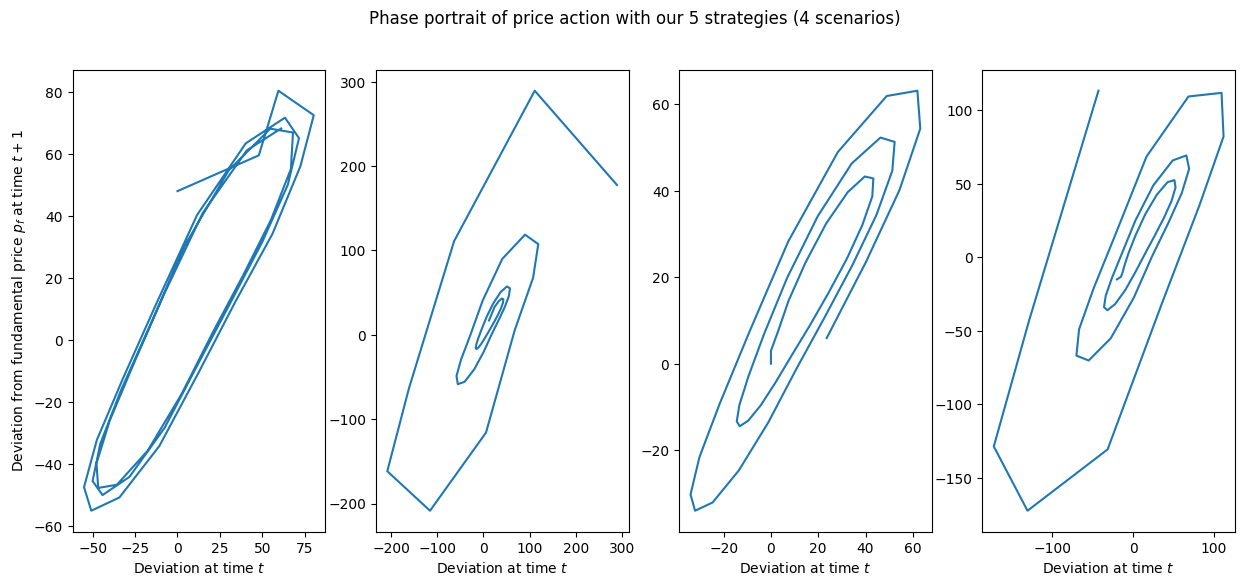

In [54]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axs[i].plot(x[i,:-1], x[i,1:], c='tab:blue')

for ax in axs.flat:
    ax.set(xlabel='Deviation at time $t$')

axs[0].set(ylabel='Deviation from fundamental price $p_f$ at time $t+1$')
    
plt.suptitle(f'Phase portrait of price action with our 5 strategies (4 scenarios)')
plt.show()

We noticed unstable behavior with higher values of $\alpha$. Indeed, a large alpha implies that the output grows more than proportionally with the increase in input, causing the system to be unstable and not converge to a steady-state.

To retrieve stability, we can reduce $\alpha$ or try to play with other parameters that may affect the system's stability such as $\beta$.